In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

In [3]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations, h for horizon, n is the size of observations used
    # e.g. compute five-step cumulative returns for the first data in S_T need the T_0-(n+4) observation 
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

In [4]:
import yfinance as yf

msft = yf.Ticker("^GDAXI")

hist = msft.history(start = '2022-12-30',end = '2024-02-15')

data_close_price = hist.drop(columns=["Open","High","Low","Volume","Dividends","Stock Splits"])

for i in range(5):
   data_close_price["ret"+str(i+1)] = compute_return(data_close_price["Close"].values, h=i+1)


In [5]:
data_cumret = data_close_price.drop(columns=["Close"]).dropna()

In [6]:
#prepare expanding window samples before 2024
data_train_list = []
due1_data_points = 221
for i in range (7):
    due_data = data_cumret.iloc[:due1_data_points].copy()
    data_train_list.append(due_data)
    due1_data_points +=5
    
print(len(data_train_list))


7


In [7]:
for i in range(len(data_train_list)):
    # Convert the index to datetime format
    data_train_list[i].index = pd.DatetimeIndex(data_train_list[i].index).to_period('D')


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_46979/672054319.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_train_list[i].index = pd.DatetimeIndex(data_train_list[i].index).to_period('D')


In [8]:
due1_data_train = data_train_list[0]

In [9]:
import statsmodels.api as sm

arma_mod_ret3 = sm.tsa.ARIMA(due1_data_train["ret3"], order=(2,0,0))
arma_res_ret3 = arma_mod_ret3.fit()
print(arma_res_ret3.summary())

                               SARIMAX Results                                
Dep. Variable:                   ret3   No. Observations:                  221
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -339.342
Date:                Tue, 02 Apr 2024   AIC                            686.685
Time:                        21:26:44   BIC                            700.278
Sample:                    01-06-2023   HQIC                           692.173
                         - 11-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1407      0.181      0.777      0.437      -0.214       0.496
ar.L1          0.6997      0.059     11.805      0.000       0.583       0.816
ar.L2         -0.1265      0.051     -2.465      0.0

In [10]:
#1 submission round 

In [11]:
due1_ret3 = due1_data_train["ret3"]

due1_lag1_ret3 = due1_ret3[:-1]
due1_lag2_ret3 = due1_ret3[:-2]

In [12]:
due1_ret3_ar2_df = pd.concat([due1_ret3,due1_lag1_ret3,due1_lag2_ret3], axis=1)

due1_ret3_ar2_df.columns = ['ret3', 'ret3_lag1','ret3_lag2']
due1_ret3_ar2_df = due1_ret3_ar2_df.iloc[::-1]
due1_ret3_ar2_df

,ret3,ret3_lag1,ret3_lag2
Date,,,
2023-11-15,3.316881,NaN,NaN
2023-11-14,1.691453,1.691453,NaN
2023-11-13,0.754881,0.754881,0.754881
2023-11-10,0.538060,0.538060,0.538060
2023-11-09,1.420692,1.420692,1.420692
...,...,...,...
2023-01-12,1.778671,1.778671,1.778671
2023-01-11,2.286394,2.286394,2.286394
2023-01-10,2.316293,2.316293,2.316293


In [13]:
due1_ret3_ar2_df['ret3_lag1']=due1_ret3_ar2_df['ret3_lag1'].shift(-1)
due1_ret3_ar2_df['ret3_lag2']=due1_ret3_ar2_df['ret3_lag2'].shift(-2)

In [14]:
#Fit quantile regresion model 
import statsmodels.formula.api as smf
tau = [.025, .25, .5, .75, .975]
estimated_values = []

due_date= due1_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due1_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))


due1_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due1_estimated_values_df) 

              0.025    0.250     0.500     0.750   0.975
Date                                                    
2023-11-15 -1.74678  0.66657  1.174961  1.854722  2.9015


In [15]:
#2 submission round 

In [16]:
due2_data_train = data_train_list[1]
due2_ret3 = due2_data_train["ret3"]

due2_lag1_ret3 = due2_ret3[:-1]
due2_lag2_ret3 = due2_ret3[:-2]

due2_ret3_ar2_df = pd.concat([due2_ret3, due2_lag1_ret3, due2_lag2_ret3], axis=1)

due2_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due2_ret3_ar2_df = due2_ret3_ar2_df.iloc[::-1]

due2_ret3_ar2_df['ret3_lag1'] = due2_ret3_ar2_df['ret3_lag1'].shift(-1)
due2_ret3_ar2_df['ret3_lag2'] = due2_ret3_ar2_df['ret3_lag2'].shift(-2)

In [17]:

estimated_values = []

due_date= due2_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due2_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due2_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due2_estimated_values_df)

               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-11-22 -2.294039 -0.080228  0.432872  1.063176  2.598829


In [18]:
#3 submission round 

In [19]:
due3_data_train = data_train_list[2]
due3_ret3 = due3_data_train["ret3"]

due3_lag1_ret3 = due3_ret3[:-1]
due3_lag2_ret3 = due3_ret3[:-2]

due3_ret3_ar2_df = pd.concat([due3_ret3, due3_lag1_ret3, due3_lag2_ret3], axis=1)

due3_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due3_ret3_ar2_df = due3_ret3_ar2_df.iloc[::-1]

due3_ret3_ar2_df['ret3_lag1'] = due3_ret3_ar2_df['ret3_lag1'].shift(-1)
due3_ret3_ar2_df['ret3_lag2'] = due3_ret3_ar2_df['ret3_lag2'].shift(-2)

estimated_values = []

due_date= due3_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due3_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due3_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due3_estimated_values_df)

               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-11-29 -2.782712 -0.499587  0.038091  0.742515  2.324851


In [20]:
#4 submission round 

In [21]:
due4_data_train = data_train_list[3]
due4_ret3 = due4_data_train["ret3"]

due4_lag1_ret3 = due4_ret3[:-1]
due4_lag2_ret3 = due4_ret3[:-2]

due4_ret3_ar2_df = pd.concat([due4_ret3, due4_lag1_ret3, due4_lag2_ret3], axis=1)

due4_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due4_ret3_ar2_df = due4_ret3_ar2_df.iloc[::-1]

due4_ret3_ar2_df['ret3_lag1'] = due4_ret3_ar2_df['ret3_lag1'].shift(-1)
due4_ret3_ar2_df['ret3_lag2'] = due4_ret3_ar2_df['ret3_lag2'].shift(-2)

estimated_values = []

due_date= due4_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due4_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due4_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due4_estimated_values_df)

               0.025     0.250     0.500    0.750     0.975
Date                                                       
2023-12-06 -1.552301  0.820754  1.267265  1.86639  3.011691


In [22]:
#5 submission round 

In [23]:
due5_data_train = data_train_list[4]
due5_ret3 = due5_data_train["ret3"]

due5_lag1_ret3 = due5_ret3[:-1]
due5_lag2_ret3 = due5_ret3[:-2]

due5_ret3_ar2_df = pd.concat([due5_ret3, due5_lag1_ret3, due5_lag2_ret3], axis=1)

due5_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due5_ret3_ar2_df = due5_ret3_ar2_df.iloc[::-1]

due5_ret3_ar2_df['ret3_lag1'] = due5_ret3_ar2_df['ret3_lag1'].shift(-1)
due5_ret3_ar2_df['ret3_lag2'] = due5_ret3_ar2_df['ret3_lag2'].shift(-2)

estimated_values = []

due_date= due5_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due5_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due5_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due5_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-12-13 -2.156785  0.154346  0.660554  1.293559  2.674436


In [24]:
#6 submission round 

In [25]:
due6_data_train = data_train_list[5]
due6_ret3 = due6_data_train["ret3"]

due6_lag1_ret3 = due6_ret3[:-1]
due6_lag2_ret3 = due6_ret3[:-2]

due6_ret3_ar2_df = pd.concat([due6_ret3, due6_lag1_ret3, due6_lag2_ret3], axis=1)

due6_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due6_ret3_ar2_df = due6_ret3_ar2_df.iloc[::-1]

due6_ret3_ar2_df['ret3_lag1'] = due6_ret3_ar2_df['ret3_lag1'].shift(-1)
due6_ret3_ar2_df['ret3_lag2'] = due6_ret3_ar2_df['ret3_lag2'].shift(-2)

estimated_values = []

due_date= due6_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due6_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due6_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due6_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-12-20 -2.855471 -0.465933  0.127375  0.910532  2.282007


In [26]:
#7 submission round - 2024

In [27]:
due7_data_train = data_cumret[:258]
due7_data_train
due7_data_train.index = pd.DatetimeIndex(due7_data_train.index).to_period('D')



/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_46979/623905567.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due7_data_train.index = pd.DatetimeIndex(due7_data_train.index).to_period('D')


In [28]:
due7_ret3 = due7_data_train["ret3"]

due7_lag1_ret3 = due7_ret3[:-1]
due7_lag2_ret3 = due7_ret3[:-2]

due7_ret3_ar2_df = pd.concat([due7_ret3, due7_lag1_ret3, due7_lag2_ret3], axis=1)

due7_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due7_ret3_ar2_df = due7_ret3_ar2_df.iloc[::-1]

due7_ret3_ar2_df['ret3_lag1'] = due7_ret3_ar2_df['ret3_lag1'].shift(-1)
due7_ret3_ar2_df['ret3_lag2'] = due7_ret3_ar2_df['ret3_lag2'].shift(-2)

estimated_values = []

due_date= due7_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due7_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due7_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due7_estimated_values_df)


             0.025     0.250     0.500     0.750     0.975
Date                                                      
2024-01-10 -2.1455 -0.279226  0.225328  0.758133  2.454617


In [29]:
#8 submission round 

In [30]:
due8_data_train = data_cumret[:258+5]
due8_data_train.index = pd.DatetimeIndex(due8_data_train.index).to_period('D')

/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_46979/91640667.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due8_data_train.index = pd.DatetimeIndex(due8_data_train.index).to_period('D')


In [31]:

due8_ret3 = due8_data_train["ret3"]

due8_lag1_ret3 = due8_ret3[:-1]
due8_lag2_ret3 = due8_ret3[:-2]

due8_ret3_ar2_df = pd.concat([due8_ret3, due8_lag1_ret3, due8_lag2_ret3], axis=1)

due8_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due8_ret3_ar2_df = due8_ret3_ar2_df.iloc[::-1]

due8_ret3_ar2_df['ret3_lag1'] = due8_ret3_ar2_df['ret3_lag1'].shift(-1)
due8_ret3_ar2_df['ret3_lag2'] = due8_ret3_ar2_df['ret3_lag2'].shift(-2)

estimated_values = []

due_date= due8_ret3_ar2_df.head(1)
for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due8_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due8_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due8_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-17 -2.497227 -0.349147  0.198088  0.932883  2.316032


In [32]:
#9 submission round

In [33]:
due9_data_train = data_cumret[:258+10]
due9_data_train.index = pd.DatetimeIndex(due9_data_train.index).to_period('D')

due9_ret3 = due9_data_train["ret3"]

due9_lag1_ret3 = due9_ret3[:-1]

due9_lag2_ret3 = due9_ret3[:-2]

due9_ret3_ar2_df = pd.concat([due9_ret3, due9_lag1_ret3, due9_lag2_ret3], axis=1)

due9_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due9_ret3_ar2_df = due9_ret3_ar2_df.iloc[::-1]

due9_ret3_ar2_df['ret3_lag1'] = due9_ret3_ar2_df['ret3_lag1'].shift(-1)
due9_ret3_ar2_df['ret3_lag2'] = due9_ret3_ar2_df['ret3_lag2'].shift(-2)

due_date= due9_ret3_ar2_df.head(1)
estimated_values = []

for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due9_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due9_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3 
print(due9_estimated_values_df)

               0.025     0.250     0.500     0.750    0.975
Date                                                       
2024-01-24 -2.125607 -0.332963  0.156481  0.646245  2.37629


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_46979/3912186577.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due9_data_train.index = pd.DatetimeIndex(due9_data_train.index).to_period('D')


In [34]:
#10 submission round

In [35]:
due10_data_train = data_cumret[:258+15]
due10_data_train.index = pd.DatetimeIndex(due10_data_train.index).to_period('D')

due10_ret3 = due10_data_train["ret3"]

due10_lag1_ret3 = due10_ret3[:-1]

due10_lag2_ret3 = due10_ret3[:-2]

due10_ret3_ar2_df = pd.concat([due10_ret3, due10_lag1_ret3, due10_lag2_ret3], axis=1)

due10_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due10_ret3_ar2_df = due10_ret3_ar2_df.iloc[::-1]

due10_ret3_ar2_df['ret3_lag1'] = due10_ret3_ar2_df['ret3_lag1'].shift(-1)
due10_ret3_ar2_df['ret3_lag2'] = due10_ret3_ar2_df['ret3_lag2'].shift(-2)

due_date= due10_ret3_ar2_df.head(1)
estimated_values = []

for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due10_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due10_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3
print(due10_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-31 -2.268199 -0.232131  0.286844  0.943371  2.392316


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_46979/3553017868.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due10_data_train.index = pd.DatetimeIndex(due10_data_train.index).to_period('D')


In [36]:
#11 submission round

In [37]:
due11_data_train = data_cumret[:258+20]
due11_data_train.index = pd.DatetimeIndex(due11_data_train.index).to_period('D')

due11_ret3 = due11_data_train["ret3"]

due11_lag1_ret3 = due11_ret3[:-1]

due11_lag2_ret3 = due11_ret3[:-2]

due11_ret3_ar2_df = pd.concat([due11_ret3, due11_lag1_ret3, due11_lag2_ret3], axis=1)

due11_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due11_ret3_ar2_df = due11_ret3_ar2_df.iloc[::-1]

due11_ret3_ar2_df['ret3_lag1'] = due11_ret3_ar2_df['ret3_lag1'].shift(-1)
due11_ret3_ar2_df['ret3_lag2'] = due11_ret3_ar2_df['ret3_lag2'].shift(-2)

due_date= due11_ret3_ar2_df.head(1)
estimated_values = []

for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due11_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due11_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3 
print(due11_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-02-07 -1.938539  0.235419  0.753008  1.478083  2.623726


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_46979/1040723525.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due11_data_train.index = pd.DatetimeIndex(due11_data_train.index).to_period('D')


In [38]:
#12 submission round

In [39]:
due12_data_train = data_cumret[:258+25]
due12_data_train.index = pd.DatetimeIndex(due12_data_train.index).to_period('D')

due12_ret3 = due12_data_train["ret3"]

due12_lag1_ret3 = due12_ret3[:-1]

due12_lag2_ret3 = due12_ret3[:-2]

due12_ret3_ar2_df = pd.concat([due12_ret3, due12_lag1_ret3, due12_lag2_ret3], axis=1)

due12_ret3_ar2_df.columns = ['ret3', 'ret3_lag1', 'ret3_lag2']
due12_ret3_ar2_df = due12_ret3_ar2_df.iloc[::-1]

due12_ret3_ar2_df['ret3_lag1'] = due12_ret3_ar2_df['ret3_lag1'].shift(-1)
due12_ret3_ar2_df['ret3_lag2'] = due12_ret3_ar2_df['ret3_lag2'].shift(-2)

due_date= due12_ret3_ar2_df.head(1)
estimated_values = []

for q in tau:
    formula = f'ret3 ~ ret3_lag1 + ret3_lag2'  
    model = smf.quantreg(formula, due12_ret3_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due12_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 3-step ahead R on T_0+3 
print(due12_estimated_values_df)


               0.025    0.250     0.500     0.750     0.975
Date                                                       
2024-02-14 -2.724013 -0.81454 -0.340087  0.219945  2.076444


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_46979/1566115990.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due12_data_train.index = pd.DatetimeIndex(due12_data_train.index).to_period('D')


In [40]:
FC_results_list = [due1_estimated_values_df, due2_estimated_values_df, due3_estimated_values_df, due4_estimated_values_df,
                  due5_estimated_values_df, due6_estimated_values_df, due7_estimated_values_df, due8_estimated_values_df,
                   due9_estimated_values_df,due10_estimated_values_df, due11_estimated_values_df, due12_estimated_values_df]
FC_results_df = pd.concat(FC_results_list, axis=0)

In [41]:
FC_results_df

,0.025,0.250,0.500,0.750,0.975
Date,,,,,
2023-11-15,-1.746780,0.666570,1.174961,1.854722,2.901500
2023-11-22,-2.294039,-0.080228,0.432872,1.063176,2.598829
2023-11-29,-2.782712,-0.499587,0.038091,0.742515,2.324851
2023-12-06,-1.552301,0.820754,1.267265,1.866390,3.011691
2023-12-13,-2.156785,0.154346,0.660554,1.293559,2.674436
2023-12-20,-2.855471,-0.465933,0.127375,0.910532,2.282007
2024-01-10,-2.145500,-0.279226,0.225328,0.758133,2.454617
2024-01-17,-2.497227,-0.349147,0.198088,0.932883,2.316032
2024-01-24,-2.125607,-0.332963,0.156481,0.646245,2.376290


In [42]:
#forcasting evaluation
realized_data = msft.history(start='2022-12-30', end='2024-02-26')
realized_data["ret3"] = compute_return(realized_data["Close"].values, h=3)

realized_data = realized_data.drop(columns=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"])
realized_data

,ret3
Date,
2022-12-30 00:00:00+01:00,NaN
2023-01-02 00:00:00+01:00,NaN
2023-01-03 00:00:00+01:00,NaN
2023-01-04 00:00:00+01:00,3.992809
2023-01-05 00:00:00+01:00,2.575427
...,...
2024-02-19 00:00:00+01:00,0.862456
2024-02-20 00:00:00+01:00,0.127452
2024-02-21 00:00:00+01:00,0.003971


In [43]:
#realized_data.index = pd.DatetimeIndex(relized_data.index).to_period('D')

In [44]:
dates =  ['2023-11-15', '2023-11-22', '2023-11-29', '2023-12-06', '2023-12-13', '2023-12-20',
         '2024-01-10', '2024-01-17', '2024-01-24', '2024-01-31', '2024-02-07', '2024-02-14']

# Increment each date by 3 day
dates_3stephead = [(pd.to_datetime(date) + pd.DateOffset(days=5)).strftime('%Y-%m-%d') for date in dates]

dates_3stephead

['2023-11-20',
 '2023-11-27',
 '2023-12-04',
 '2023-12-11',
 '2023-12-18',
 '2023-12-25',
 '2024-01-15',
 '2024-01-22',
 '2024-01-29',
 '2024-02-05',
 '2024-02-12',
 '2024-02-19']

In [49]:
realized_data.loc['2023-12-25 00:00:00+01:00'] = 0.00
realized_data.index = pd.to_datetime(realized_data.index)
realized_data = realized_data.sort_index()

In [50]:
# Use the incremented dates to select data from realized_data

realized_T03 = realized_data.loc[dates_3stephead]

In [51]:
def quantile_score(q_hat, y, tau):
    scores = []
    for i in range(len(tau)):
        if q_hat[i] > y:
            score = 2 * (1 - tau[i]) * (q_hat[i] - y)
        elif y >= q_hat[i]:
            score = 2 * tau[i] * (y - q_hat[i])
        else:
            score = 0
        scores.append(score)
    return scores

ret_3_scores = []


# Iterate over each submission day (row) in FC_results

for i in range(FC_results_df.shape[0]):
    q_hat = FC_results_df.iloc[i].values
    y = realized_T03.iloc[i].values
    scores = quantile_score(q_hat, y, tau)
    ret_3_scores.append(scores)
    
ret_3_scores

[[array([0.13573197]),
  array([0.15064496]),
  array([0.20710176]),
  array([0.44343148]),
  array([0.096682])],
 [array([0.1173801]),
  array([0.0668957]),
  array([0.37930874]),
  array([0.50480642]),
  array([0.1272633])],
 [array([0.21230263]),
  array([0.98146345]),
  array([1.42524883]),
  array([1.08123819]),
  array([0.04307552])],
 [array([0.11886689]),
  array([0.00214135]),
  array([0.44222801]),
  array([0.52067667]),
  array([0.10933268])],
 [array([0.07327546]),
  array([1.26843226]),
  array([1.35183]),
  array([0.99241735]),
  array([0.16828558])],
 [array([0.14277355]),
  array([0.23296671]),
  array([0.12737533]),
  array([0.45526621]),
  array([0.11410037])],
 [array([0.08698507]),
  array([0.18985993]),
  array([0.63112699]),
  array([0.58196583]),
  array([0.14302079])],
 [array([0.20086149]),
  array([0.93457493]),
  array([1.32191442]),
  array([0.88067899]),
  array([0.03980149])],
 [array([0.12158885]),
  array([0.31956621]),
  array([0.14968808]),
  array([0.

In [52]:
columns = ['due1', 'due2', 'due3', 'due4', 'due5', 'due6', 'due7', 'due8', 'due9', 'due10', 'due11', 'due12']
ret_3_scores_df = pd.DataFrame(ret_3_scores).T
ret_3_scores_df.columns = columns
ret_3_scores_df.index = tau

In [53]:
ret_3_scores_df

,due1,due2,due3,due4,due5,due6,due7,due8,due9,due10,due11,due12
0.025,[0.1357319734697706],[0.11738010409005886],[0.2123026326472771],[0.1188668897713901],[0.0732754607338382],[0.14277354576663887],[0.08698506763593038],[0.20086149192947486],[0.1215888457939942],[0.11349893041342783],[0.13090558333217994],[0.17932344314407075]
0.250,[0.1506449645484273],[0.06689570366399628],[0.9814634534883429],[0.002141353724975703],[1.2684322609307523],[0.23296670773626485],[0.18985992756559866],[0.9345749284434784],[0.319566210071064],[0.11695523376863871],[0.22207707203429],[0.8384979634730514]
0.500,[0.20710175992871105],[0.3793087364476655],[1.4252488251656308],[0.44222800643520843],[1.3518300029988888],[0.1273753266988914],[0.6311269923531458],[1.3219144160920668],[0.1496880793871758],[0.28506469641617566],[0.07343521175795997],[1.2025427864160387]
0.750,[0.4434314750884383],[0.5048064236736176],[1.0812381946070364],[0.520676674582739],[0.9924173500260214],[0.4552662084417321],[0.5819658327680911],[0.8806789903278069],[0.17003778104591133],[0.4707958215459866],[0.39925506013011447],[0.9637653831684039]
0.975,[0.09668200463112815],[0.1272632960139703],[0.043075524659906],[0.10933268423253771],[0.16828557617754963],[0.11410037262848262],[0.14302078931261433],[0.03980148691559574],[0.10350603358454791],[0.11952685283979464],[0.09720766293008729],[0.060699415451839246]


In [54]:
ret_3_scores_df=ret_3_scores_df.astype(float)

In [55]:
ret_3_scores_df

,due1,due2,due3,due4,due5,due6,due7,due8,due9,due10,due11,due12
0.025,0.135732,0.117380,0.212303,0.118867,0.073275,0.142774,0.086985,0.200861,0.121589,0.113499,0.130906,0.179323
0.250,0.150645,0.066896,0.981463,0.002141,1.268432,0.232967,0.189860,0.934575,0.319566,0.116955,0.222077,0.838498
0.500,0.207102,0.379309,1.425249,0.442228,1.351830,0.127375,0.631127,1.321914,0.149688,0.285065,0.073435,1.202543
0.750,0.443431,0.504806,1.081238,0.520677,0.992417,0.455266,0.581966,0.880679,0.170038,0.470796,0.399255,0.963765
0.975,0.096682,0.127263,0.043076,0.109333,0.168286,0.114100,0.143021,0.039801,0.103506,0.119527,0.097208,0.060699


<Axes: >

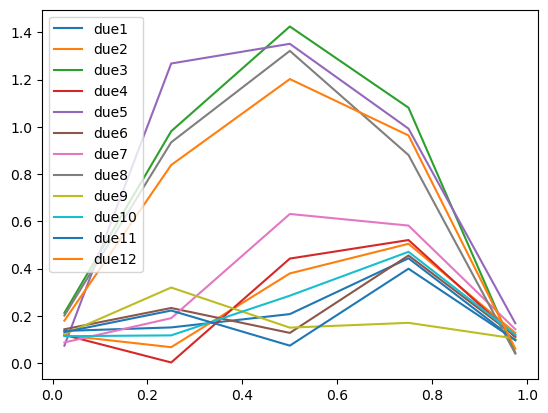

In [56]:
ret_3_scores_df.plot()